In [9]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from __future__ import annotations
from typing import Any, Callable, List, Optional, Tuple

import os
import sys

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from plotting_tools.formatting import calculate_best_figure_dimensions
from coordination.component.serialized_mass_spring_damper_component import SerializedMassSpringDamperComponent
from coordination.model.serial_argument_model import SerialArgumentModel, SerialArgumentSeries, SerialArgumentSamples
from coordination.model.mass_spring_damper_model import MassSpringDamperModel
from coordination.model.coordination_model import CoordinationPosteriorSamples

# Style

In [45]:
plt.style.use("seaborn-v0_8-darkgrid")

tex_fonts = {
    "axes.labelsize": 6,
    "font.size": 6,
    "legend.fontsize": 8,
    "xtick.labelsize": 4,
    "ytick.labelsize": 4,
    "axes.titlesize": 8,
}
plt.rcParams.update(tex_fonts)
plt.rc('pdf',fonttype = 42)
plt.rcParams['text.usetex'] = True
# plt.rcParams["font.family"] = "Times New Roman"

sns.color_palette("Set2")

DOC = "neurips"
TARGET_DIR = "/work/paulosoares/results/neurips_2023"

def save_plot(image_name: str, fig: Any):
    fig.savefig(f"{TARGET_DIR}/{image_name}.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

# Constants

In [27]:
T=100

# Color palette with good contrast: green, pink, cyan, mustard
COLORS_SPR = ["#137513", "#FF9090", "#13B2FF"]
COLORS_ARG = ["#FF9090", "#13B2FF"]
RED = "#fabbb5"
GREEN = "#7fdc9a"
BLUE = "#afcdff"
MUSTARD = "#BE9700"
PINK = "#f9b1f0"
# COLORS = [RED, GREEN, BLUE]


# Mass-spring-damper model
NUM_SPRINGS=3
SPRING_CONSTANT=np.array([16, 8, 4])
MASS=np.ones(NUM_SPRINGS) * 10
DAMPING_COEF_SPR=np.zeros(NUM_SPRINGS)
DT_SPR=0.2
INITIAL_STATE_SPR=np.array([[1, 0], [3, 0], [5, 0]])
SD_AA_SPR=0.1  # noise in the model evolution
SD_O_SPR=0.1   # noise in the measurement
SPRING_DEPENDENCIES=np.array([[1/2, 1/2], [1/2, 1/2], [1/2, 1/2]]) # Remove this later when weights get out of the equation

# Argument model 
NUM_SUBJECTS=2
SUBJECT_NAMES=["Bob", "Alice"]
FREQ=np.array([0.8, 0.2])
DAMPING_COEF_ARG=np.zeros(NUM_SUBJECTS)
DT_ARG=0.2
INITIAL_STATE_ARG=np.array([[1, 0], [1, 0]])
SD_AA_ARG=0.1  # noise in the model evolution
SD_O_ARG=0.01 # noise in the measurement

# Inference
SEED = 0
BURN_IN = 2000
NUM_SAMPLES = 2000
NUM_CHAINS = 4
NUTS_INIT_METHOD = "jitter+adapt_diag"
TARGET_ACCEPT = 0.9

# Model

## a) Spring

In [28]:
spring_model = MassSpringDamperModel(num_springs=NUM_SPRINGS,
                                     spring_constant=SPRING_CONSTANT,
                                     mass=MASS,
                                     damping_coefficient=DAMPING_COEF_SPR,
                                     dt=DT_SPR,
                                     self_dependent=True,
                                     sd_mean_uc0=1,
                                     sd_sd_uc=1,
                                     mean_mean_a0=np.zeros((NUM_SPRINGS, 2)),
                                     sd_mean_a0=np.ones((NUM_SPRINGS, 2)) * max(INITIAL_STATE_SPR[:, 0]),  # Maximum value among initial positions not to make hyperprior too tight
                                     sd_sd_aa=np.ones(1),
                                     a_mixture_weights=np.ones((NUM_SPRINGS, NUM_SPRINGS - 1)),
                                     sd_sd_o=np.ones(1),
                                     share_sd_aa_across_springs=True,
                                     share_sd_aa_across_features=True,  # same variance for position and speed
                                     share_sd_o_across_springs=True,    # same measurement noise for different springs
                                     share_sd_o_across_features=True)   # same measurement noise for position and speed                               

## b) Argument

In [14]:
argument_model = SerialArgumentModel(num_subjects=NUM_SUBJECTS,
                                     frequency=FREQ,
                                     damping_coefficient=DAMPING_COEF_ARG,
                                     dt=DT_ARG,
                                     self_dependent=True,
                                     sd_mean_uc0=1,
                                     sd_sd_uc=1,
                                     mean_mean_a0=np.zeros((NUM_SUBJECTS, 2)),
                                     sd_mean_a0=np.ones((NUM_SUBJECTS, 2)) * max(INITIAL_STATE_ARG[:, 0]),
                                     sd_sd_aa=np.ones(1),
                                     sd_sd_o=np.ones(1),
                                     share_sd_aa_across_subjects=True,
                                     share_sd_aa_across_features=True,
                                     share_sd_o_across_subjects=True,
                                     share_sd_o_across_features=True)

# Synthetic Data

## Helper Functions

In [15]:
def plot_spring_data(ax: Any, data: np.ndarray, marker_size: int = 8, marker: str = "o", title: str = "", skip:int = 0):
    num_time_steps = data.shape[-1]
    
    tt = np.arange(num_time_steps)
    indices = np.arange(0,num_time_steps) 
    
    if skip > 1:
        # We might drop some points for better visualization
        indices = [i for i in indices if i == 0 or (i % skip) != 0]
    
    for s in range(NUM_SPRINGS):
        ax.scatter(tt[indices], data[s, 0][indices], label=f"Spring {s + 1}", s=marker_size, marker=marker, c=COLORS_SPR[s])
    ax.set_title(title)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Position")
    
def plot_argument_data(ax: Any, data: ArgumentSeries, marker_size: int = 8, marker: str = "o", title: str = "", skip:int = 0):
    for s, name in enumerate(SUBJECT_NAMES):
        tt = np.array([t for t, subject in enumerate(data.subjects_in_time) if s == subject])
        indices = np.arange(0,len(tt),skip+1) # We might drop some points for better visualization
        ax.scatter(tt[indices], data.observation[0, tt][indices], label=name, s=marker_size, marker=marker, c=COLORS_ARG[s])
    ax.set_title(title)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Position")
    
def argument_samples_to_evidence(samples: SerialArgumentSamples) -> SerialArgumentSeries:
    return SerialArgumentSeries(subjects_in_time=samples.state.subjects[0],
                                prev_time_same_subject=samples.state.prev_time_same_subject[0],
                                prev_time_diff_subject=samples.state.prev_time_diff_subject[0],
                                observation=samples.observation.values[0])    

## a) Spring

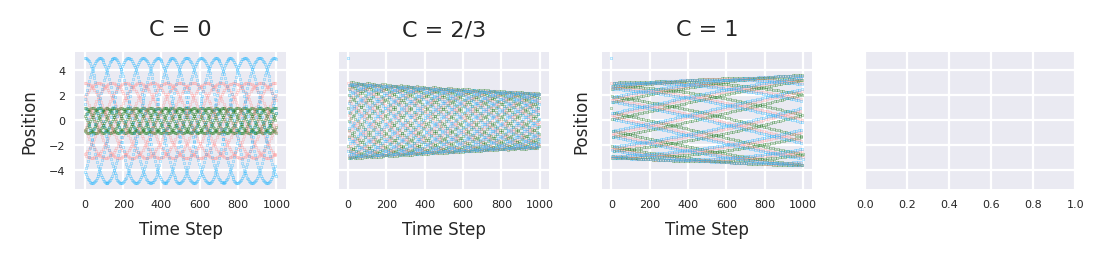

In [29]:
# Set parameters for data generation
spring_model.state_space_cpn.parameters.mean_a0.value=INITIAL_STATE_SPR
spring_model.state_space_cpn.parameters.mixture_weights.value=SPRING_DEPENDENCIES
spring_model.state_space_cpn.parameters.sd_aa.value=np.zeros(1)  # only for plots
spring_model.observation_cpn.parameters.sd_o.value=np.zeros(1)

# Unoised version is only used for plots
T_plot = 20000
coordination = np.zeros((1, T_plot))
spring_uncoordinated_data = spring_model.draw_samples(num_series=1, num_time_steps=T_plot, coordination_samples=coordination, seed=0).observation.values[0]

coordination = np.ones((1, T_plot)) * 2/3
spring_coordinated_data = spring_model.draw_samples(num_series=1, num_time_steps=T_plot, coordination_samples=coordination, seed=0).observation.values[0]

coordination = np.ones((1, T_plot))
spring_supercoordinated_data = spring_model.draw_samples(num_series=1, num_time_steps=T_plot, coordination_samples=coordination, seed=0).observation.values[0]

# Noisy version
spring_model.state_space_cpn.parameters.sd_aa.value=np.ones(1) * SD_AA_SPR
spring_model.observation_cpn.parameters.sd_o.value=np.ones(1) * SD_O_SPR

coordination = np.zeros((1, T))
noisy_spring_uncoordinated_data = spring_model.draw_samples(num_series=1, num_time_steps=T, coordination_samples=coordination, seed=0).observation.values[0]

coordination = np.ones((1, T)) * 2/3
noisy_spring_coordinated_data = spring_model.draw_samples(num_series=1, num_time_steps=T, coordination_samples=coordination, seed=0).observation.values[0]

coordination = np.ones((1, T))
noisy_spring_supercoordinated_data = spring_model.draw_samples(num_series=1, num_time_steps=T, coordination_samples=coordination, seed=0).observation.values[0]

# Plot data
w, h = calculate_best_figure_dimensions(document_width=DOC, scale=1, subplots=(1,4))  
fig, axs = plt.subplots(1, 4, figsize=(w,h*1.5), sharey=True)

plot_spring_data(axs[0], spring_uncoordinated_data[..., 0:-1:20], marker_size=0.01, title=f"C = 0", skip=1)
plot_spring_data(axs[1], spring_coordinated_data[..., 0:-1:20], marker_size=0.01, title=f"C = 2/3", skip=1)
plot_spring_data(axs[2], spring_supercoordinated_data[..., 0:-1:20], marker_size=0.01, title=f"C = 1", skip=1)
axs[1].set_ylabel("")
plt.tight_layout()

## b) Argument

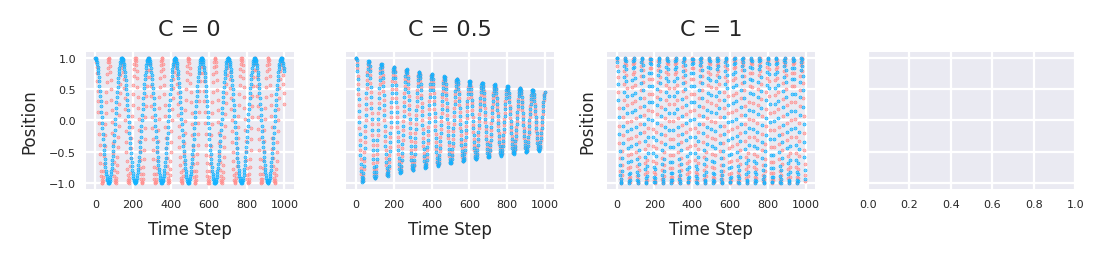

In [17]:
# Set parameters for data generation
argument_model.state_space_cpn.parameters.mean_a0.value=INITIAL_STATE_ARG
argument_model.state_space_cpn.parameters.sd_aa.value=np.zeros(1)
argument_model.observation_cpn.parameters.sd_o.value=np.zeros(1)

# Unoised version is only used for plots
T_plot = 1000
coordination = np.zeros((1, T_plot))
argument_uncoordinated_data = argument_samples_to_evidence(argument_model.draw_samples(num_series=1, num_time_steps=T_plot, coordination_samples=coordination, seed=0))

coordination = np.ones((1, T_plot)) * 0.5
argument_coordinated_data = argument_samples_to_evidence(argument_model.draw_samples(num_series=1, num_time_steps=T_plot, coordination_samples=coordination, seed=0))

coordination = np.ones((1, T_plot))
argument_supercoordinated_data = argument_samples_to_evidence(argument_model.draw_samples(num_series=1, num_time_steps=T_plot, coordination_samples=coordination, seed=0))

# Noisy version
argument_model.state_space_cpn.parameters.sd_aa.value=np.ones(1) * SD_AA_ARG
argument_model.observation_cpn.parameters.sd_o.value=np.ones(1) * SD_O_ARG

coordination = np.zeros((1, T))
noisy_argument_uncoordinated_data = argument_samples_to_evidence(argument_model.draw_samples(num_series=1, num_time_steps=T, coordination_samples=coordination, seed=0))

coordination = np.ones((1, T)) * 0.5
noisy_argument_coordinated_data = argument_samples_to_evidence(argument_model.draw_samples(num_series=1, num_time_steps=T, coordination_samples=coordination, seed=0))

coordination = np.ones((1, T))
noisy_argument_supercoordinated_data = argument_samples_to_evidence(argument_model.draw_samples(num_series=1, num_time_steps=T, coordination_samples=coordination, seed=0))

# Plot data
w, h = calculate_best_figure_dimensions(document_width=DOC, scale=1, subplots=(1,4))  
fig, axs = plt.subplots(1, 4, figsize=(w,h*1.5), sharey=True)

plot_argument_data(axs[0], argument_uncoordinated_data, marker_size=0.1, title=f"C = 0", skip=0)
plot_argument_data(axs[1], argument_coordinated_data, marker_size=0.1, title=f"C = 0.5", skip=0)
plot_argument_data(axs[2], argument_supercoordinated_data, marker_size=0.1, title=f"C = 1", skip=0)
axs[1].set_ylabel("")
plt.tight_layout()

# Experiments

## Helper Functions

In [18]:
def train(model: Any, 
          evidence: Any, 
          init_method: str = "jitter+adapt_diag",
          burn_in: int = 1000, 
          num_samples: int = 1000, 
          num_chains: int = 2, 
          seed : int = 0):
    
    # Ignore PyMC warnings
    if not sys.warnoptions:
        import warnings
        warnings.simplefilter("ignore")
    
    # The environment variables below will make sure each chain do not take all the resources, slowing down inference.
    os.environ["MKL_NUM_THREADS"] = f"{NUM_CHAINS}"
    os.environ["OMP_NUM_THREADS"] = f"{NUM_CHAINS}"
    os.environ["OPENBLAS_NUM_THREADS"] = f"{NUM_CHAINS}"
    
    model.clear_parameter_values()  # so we can infer them
    _, idata = model.fit(evidence = evidence, 
                         init_method = init_method,
                         burn_in = burn_in, 
                         num_samples = num_samples, 
                         num_chains = num_chains,
                         seed = seed, 
                         num_jobs = num_chains)
    
    posterior_samples = CoordinationPosteriorSamples.from_inference_data(idata)
    
    # Plot parameter trace
    plot_parameter_trace(model, idata)

    # Plot coordination
    w, h = calculate_best_figure_dimensions(document_width=DOC, scale=1)  
    fig = plt.figure(figsize=(w,h))
    
    posterior_samples.plot(fig.gca(), show_samples=False, line_width=1)
    plt.title("Coordination")
    
    return posterior_samples, idata

def plot_parameter_trace(model: Any, idata: Any):
    sampled_vars = set(idata.posterior.data_vars)
    var_names = sorted(list(set(model.parameter_names).intersection(sampled_vars)))    
    az.plot_trace(idata, var_names=var_names)
    plt.tight_layout()

def build_convergence_summary(idata: Any) -> pd.DataFrame:
    header = [
        "variable",
        "mean_rhat",
        "std_rhat"
    ]
    
    rhat = az.rhat(idata)
    data = []
    for var, values in rhat.data_vars.items():
        entry = [
            var,
            values.to_numpy().mean(),
            values.to_numpy().std()
        ]
        data.append(entry)

    return pd.DataFrame(data, columns=header)

## 1) No Coordination

### 1.1) Spring

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_uc0, sd_uc, unbounded_coordination, mean_a0_state_space, sd_aa_state_space, mixture_weights_state_space, state_space, sd_o_observation]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 174 seconds.


variable  mean_rhat  std_rhat
0                     mean_uc0   1.004110  0.000000
1       unbounded_coordination   1.064988  0.032413
2          mean_a0_state_space   1.000419  0.000285
3                  state_space   1.000339  0.000361
4                        sd_uc   1.064654  0.000000
5            sd_aa_state_space   1.009325  0.000000
6  mixture_weights_state_space   1.001161  0.000431
7             sd_o_observation   1.004990  0.000000
8                 coordination   1.064959  0.032469

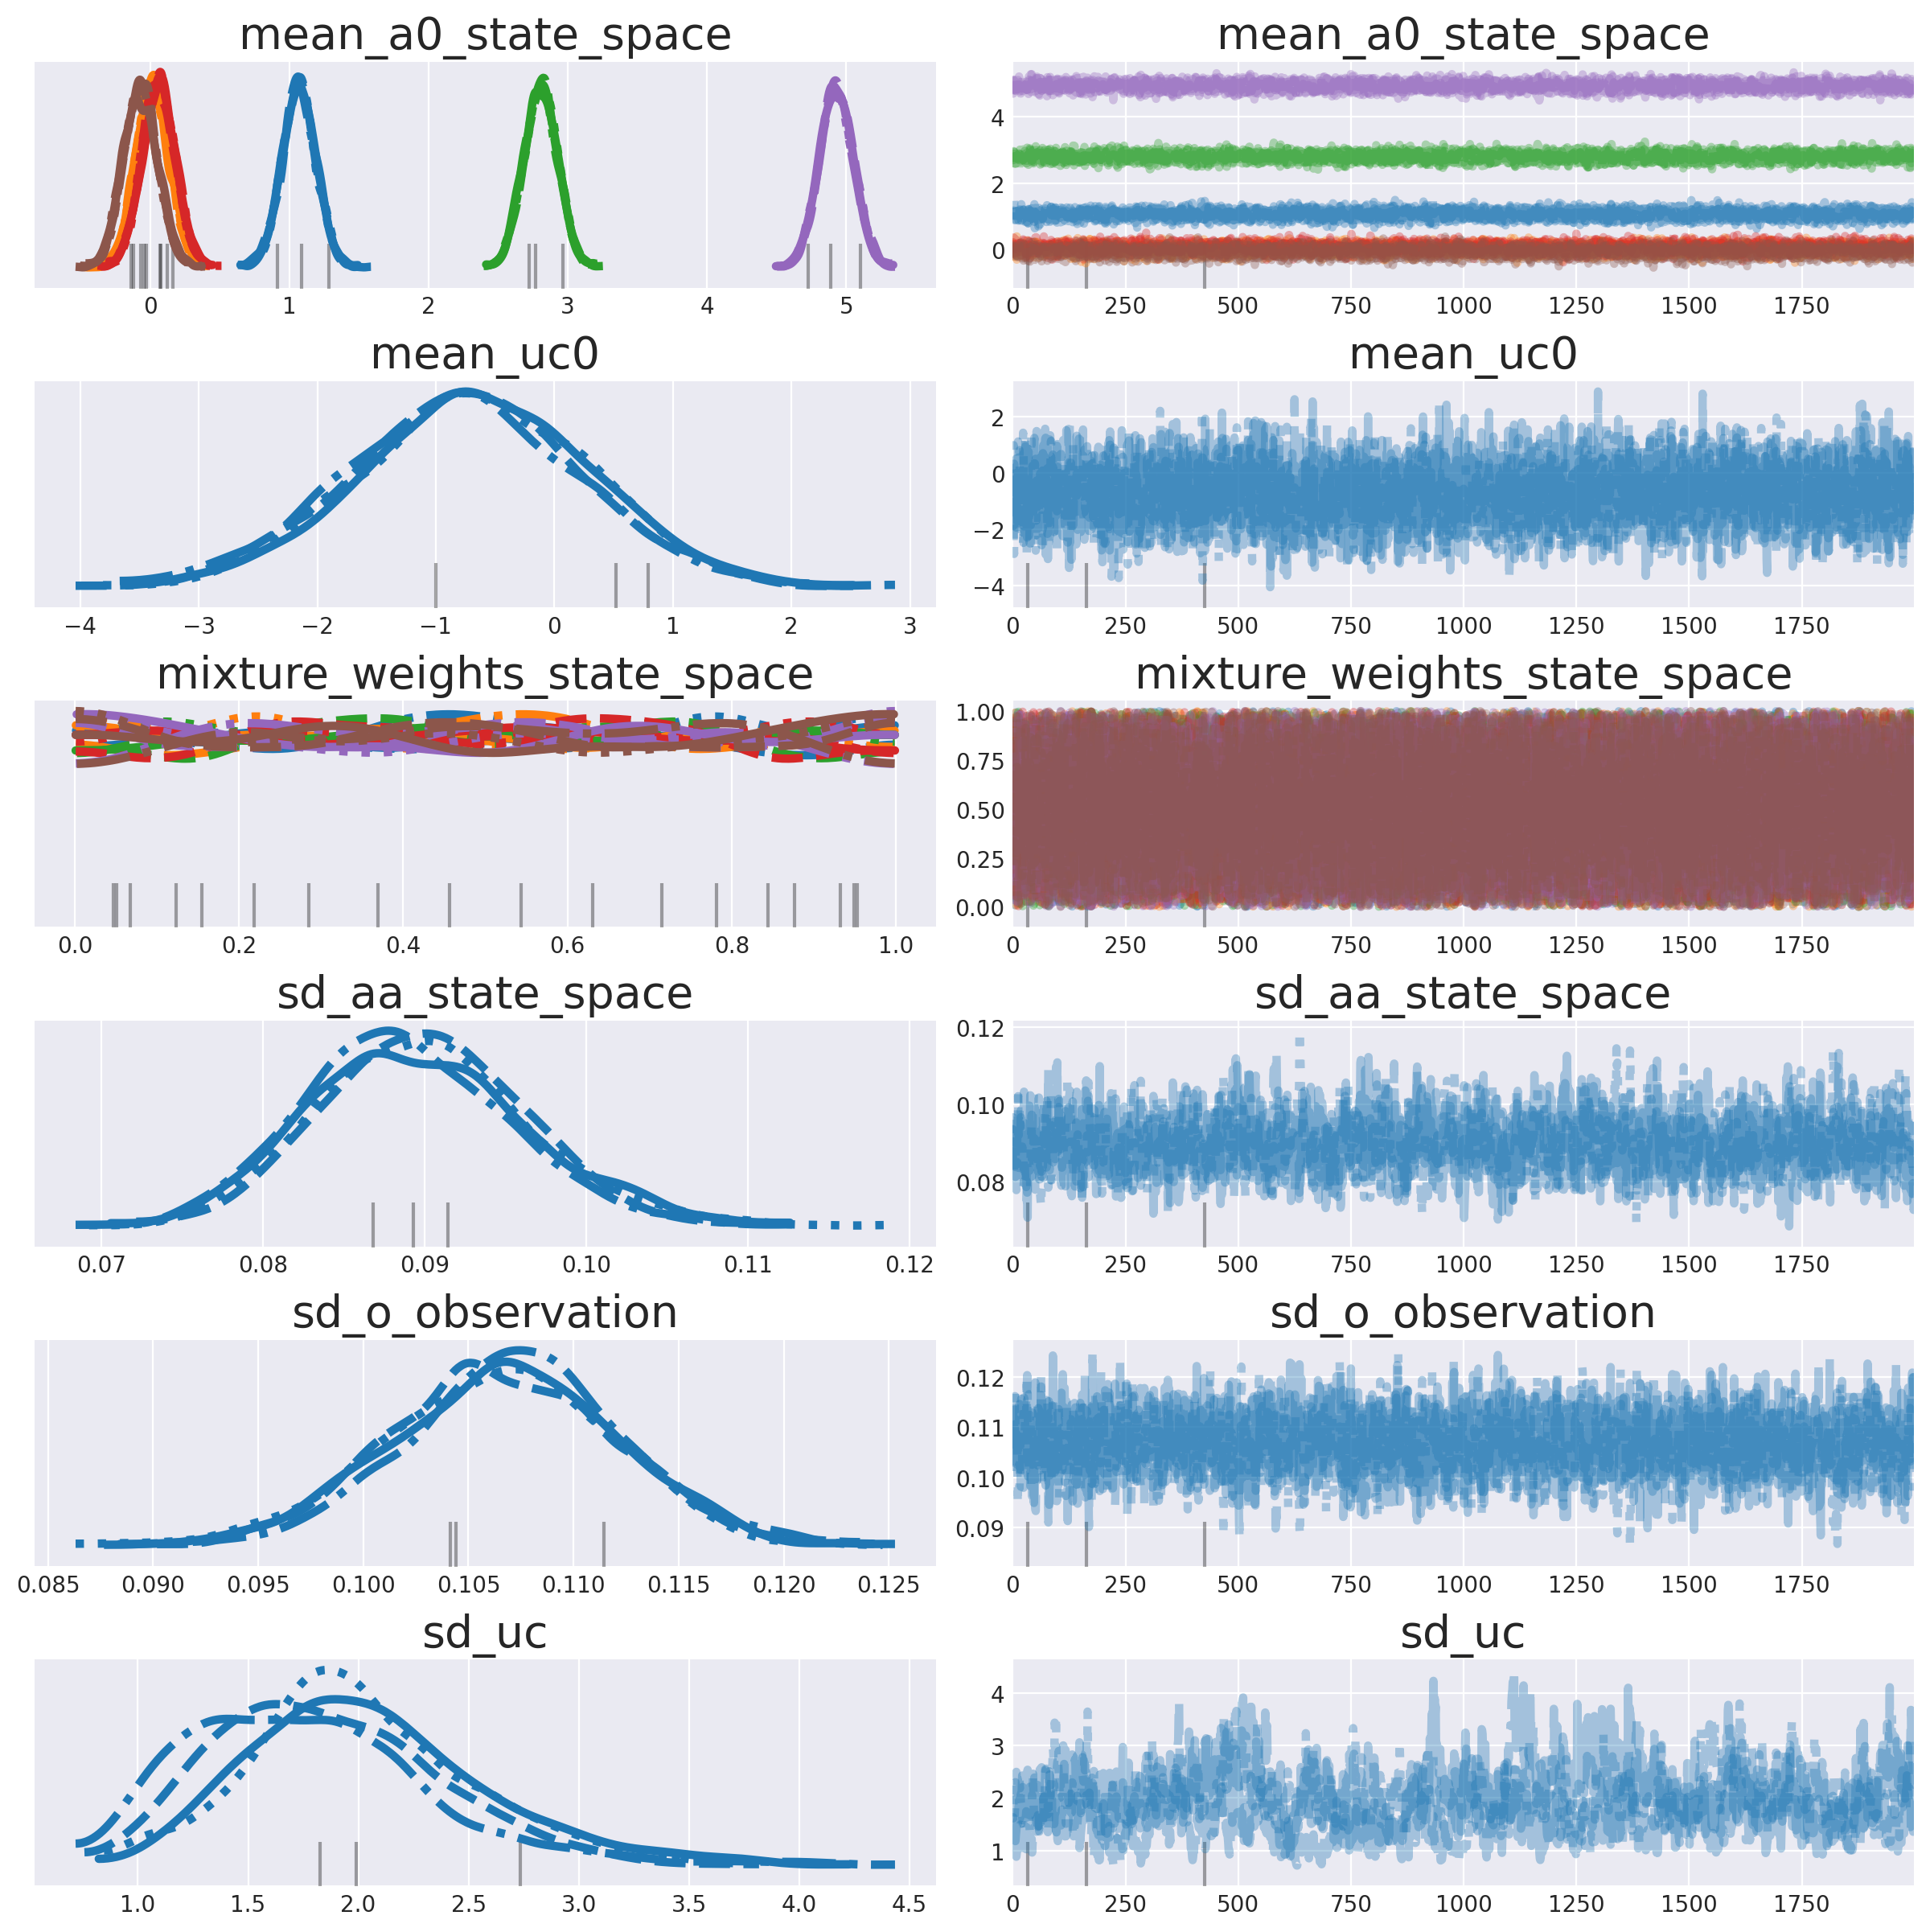

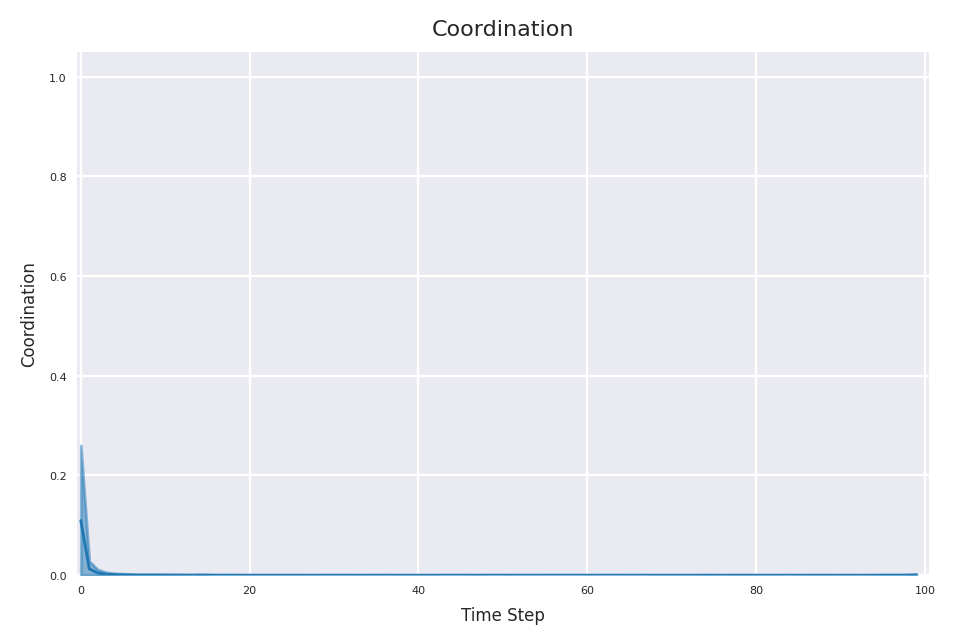

In [30]:
evidence = noisy_spring_uncoordinated_data

c_posterior_spring_uncoordinated, idata_spring_uncoordinated = train(spring_model, evidence, burn_in=BURN_IN, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, init_method=NUTS_INIT_METHOD)
build_convergence_summary(idata_spring_uncoordinated)

### 1.2) Argument

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mean_uc0, sd_uc, unbounded_coordination, mean_a0_state_space, sd_aa_state_space, state_space, sd_o_observation]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 33 seconds.


variable  mean_rhat  std_rhat
0                mean_uc0   1.014596  0.000000
1  unbounded_coordination   1.230299  0.175366
2     mean_a0_state_space   1.005880  0.006672
3             state_space   1.090378  0.018714
4                   sd_uc   1.110118  0.000000
5       sd_aa_state_space   1.101241  0.000000
6        sd_o_observation   1.693522  0.000000
7            coordination   1.230506  0.175605

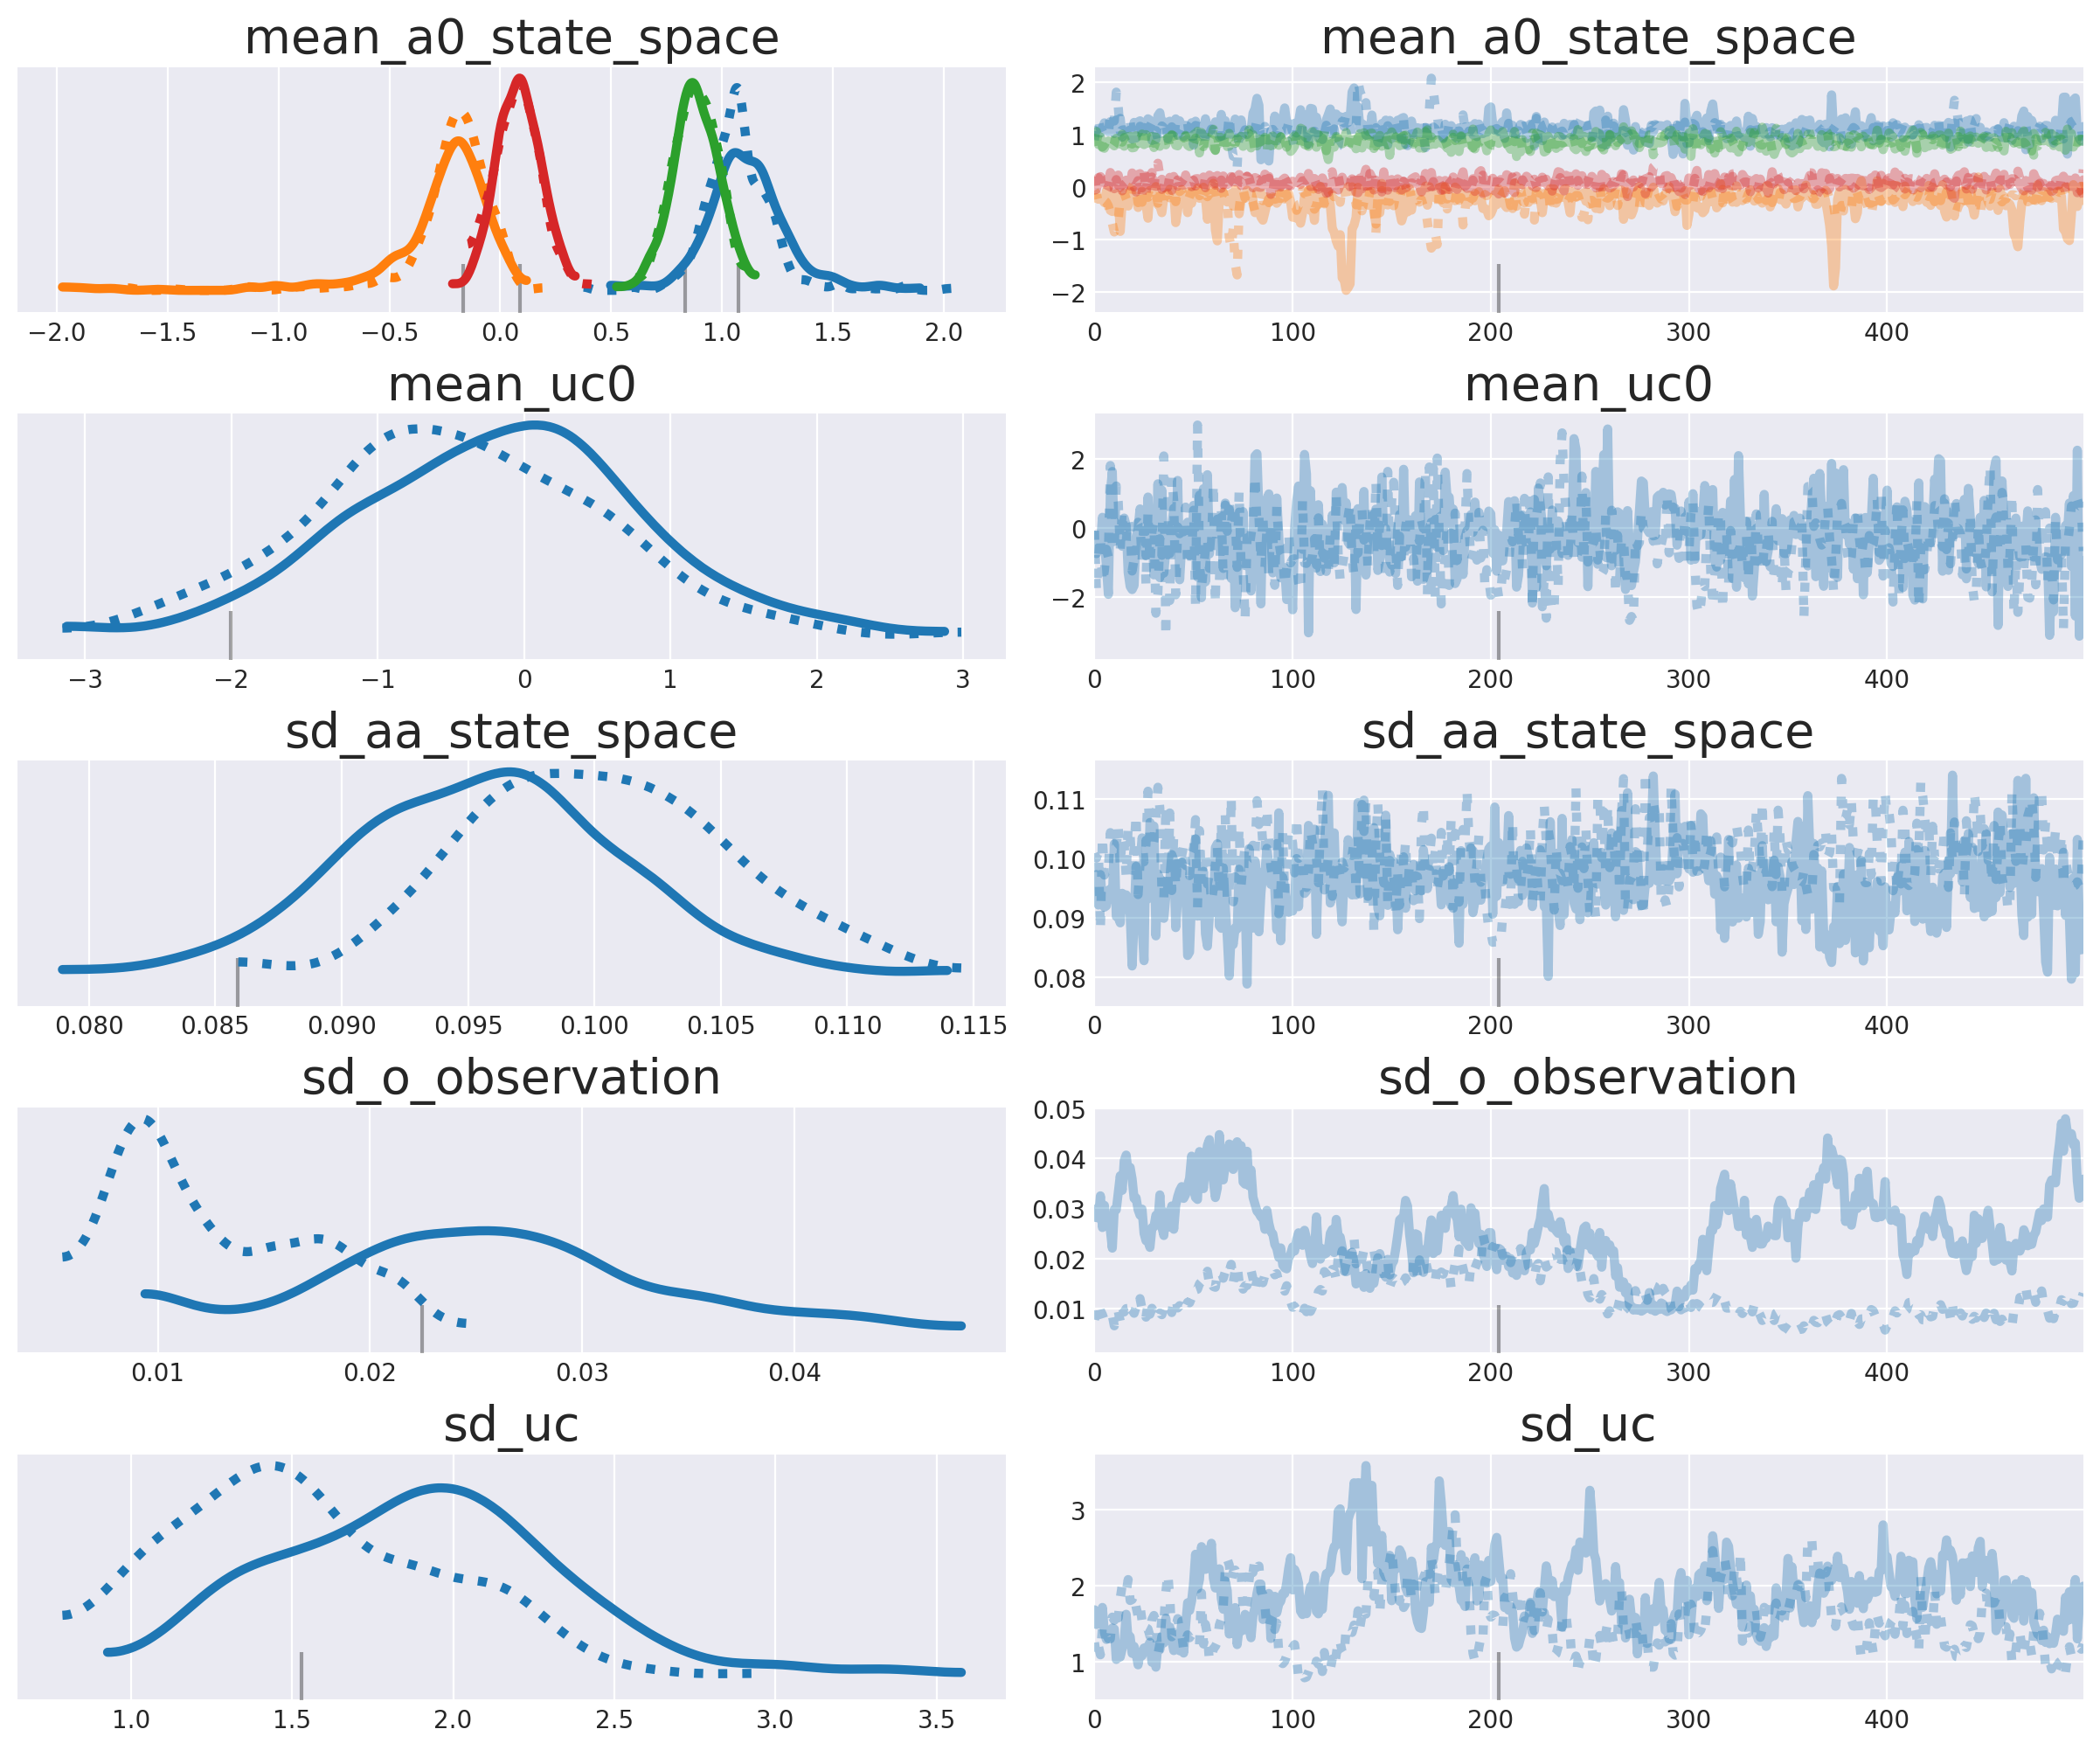

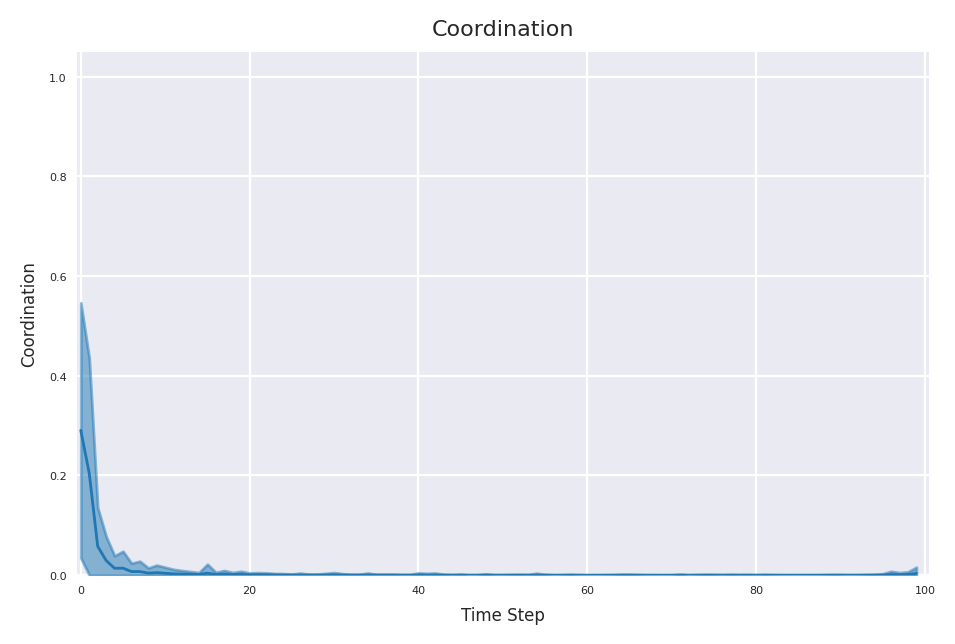

In [20]:
evidence = noisy_argument_uncoordinated_data

c_posterior_argument_uncoordinated, idata_argument_uncoordinated = train(argument_model, evidence, burn_in=500, num_samples=500, num_chains=2, init_method=NUTS_INIT_METHOD)
build_convergence_summary(idata_argument_uncoordinated)

## 2) Maximum Coordination

### 1.1) Spring

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_uc0, sd_uc, unbounded_coordination, mean_a0_state_space, sd_aa_state_space, mixture_weights_state_space, state_space, sd_o_observation]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 234 seconds.


variable  mean_rhat  std_rhat
0                     mean_uc0   1.053467  0.000000
1       unbounded_coordination   1.048960  0.024925
2          mean_a0_state_space   1.021336  0.015713
3                  state_space   1.034052  0.021349
4                        sd_uc   1.068514  0.000000
5            sd_aa_state_space   1.099963  0.000000
6  mixture_weights_state_space   1.065820  0.023355
7             sd_o_observation   1.047281  0.000000
8                 coordination   1.048782  0.024771

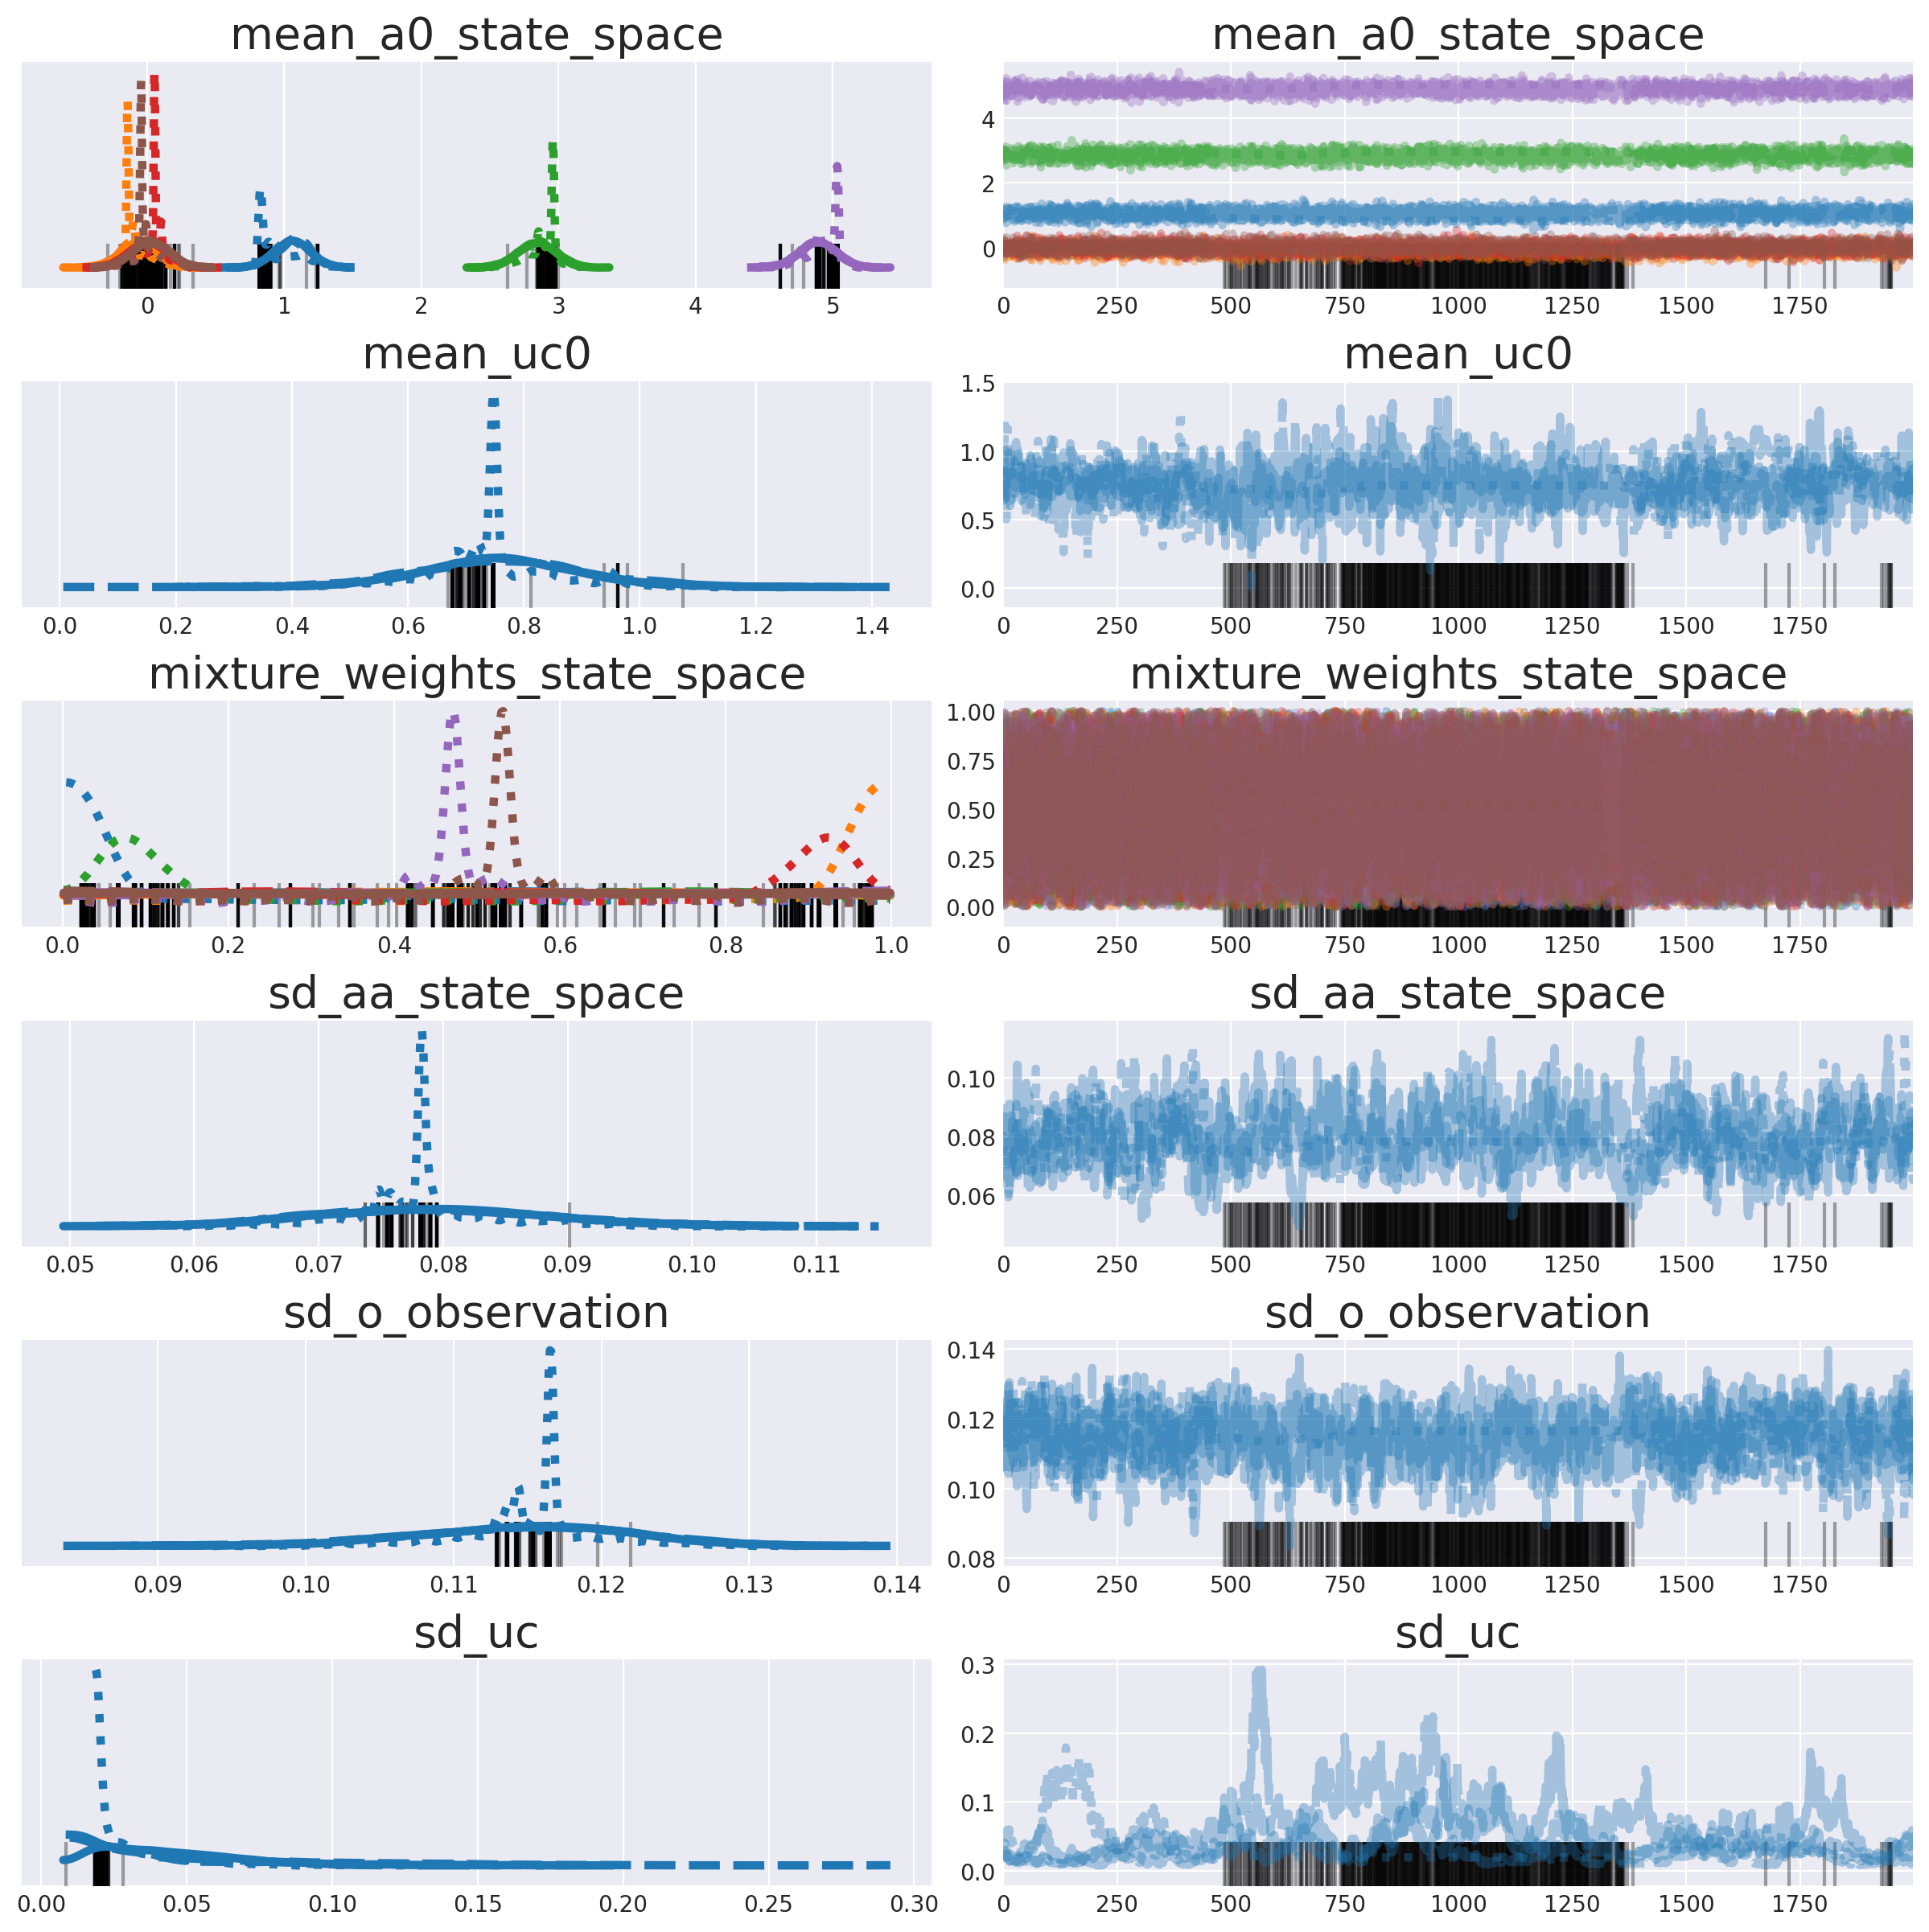

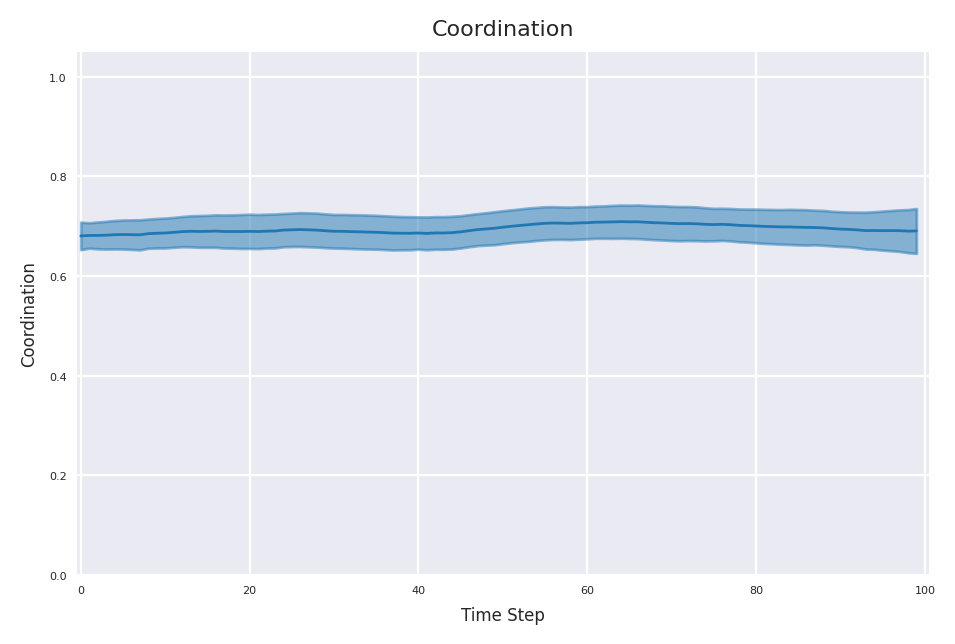

In [31]:
evidence = noisy_spring_coordinated_data

c_posterior_spring_coordinated, idata_spring_coordinated = train(spring_model, evidence, burn_in=BURN_IN, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, init_method=NUTS_INIT_METHOD)
build_convergence_summary(idata_spring_coordinated)

### 1.2) Argument

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_uc0, sd_uc, unbounded_coordination, mean_a0_state_space, sd_aa_state_space, state_space, sd_o_observation]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 322 seconds.


variable  mean_rhat  std_rhat
0                mean_uc0   1.038360  0.000000
1  unbounded_coordination   1.063709  0.023430
2     mean_a0_state_space   1.001844  0.001502
3             state_space   1.014277  0.003246
4                   sd_uc   1.264289  0.000000
5       sd_aa_state_space   1.026737  0.000000
6        sd_o_observation   1.079017  0.000000
7            coordination   1.063375  0.023455

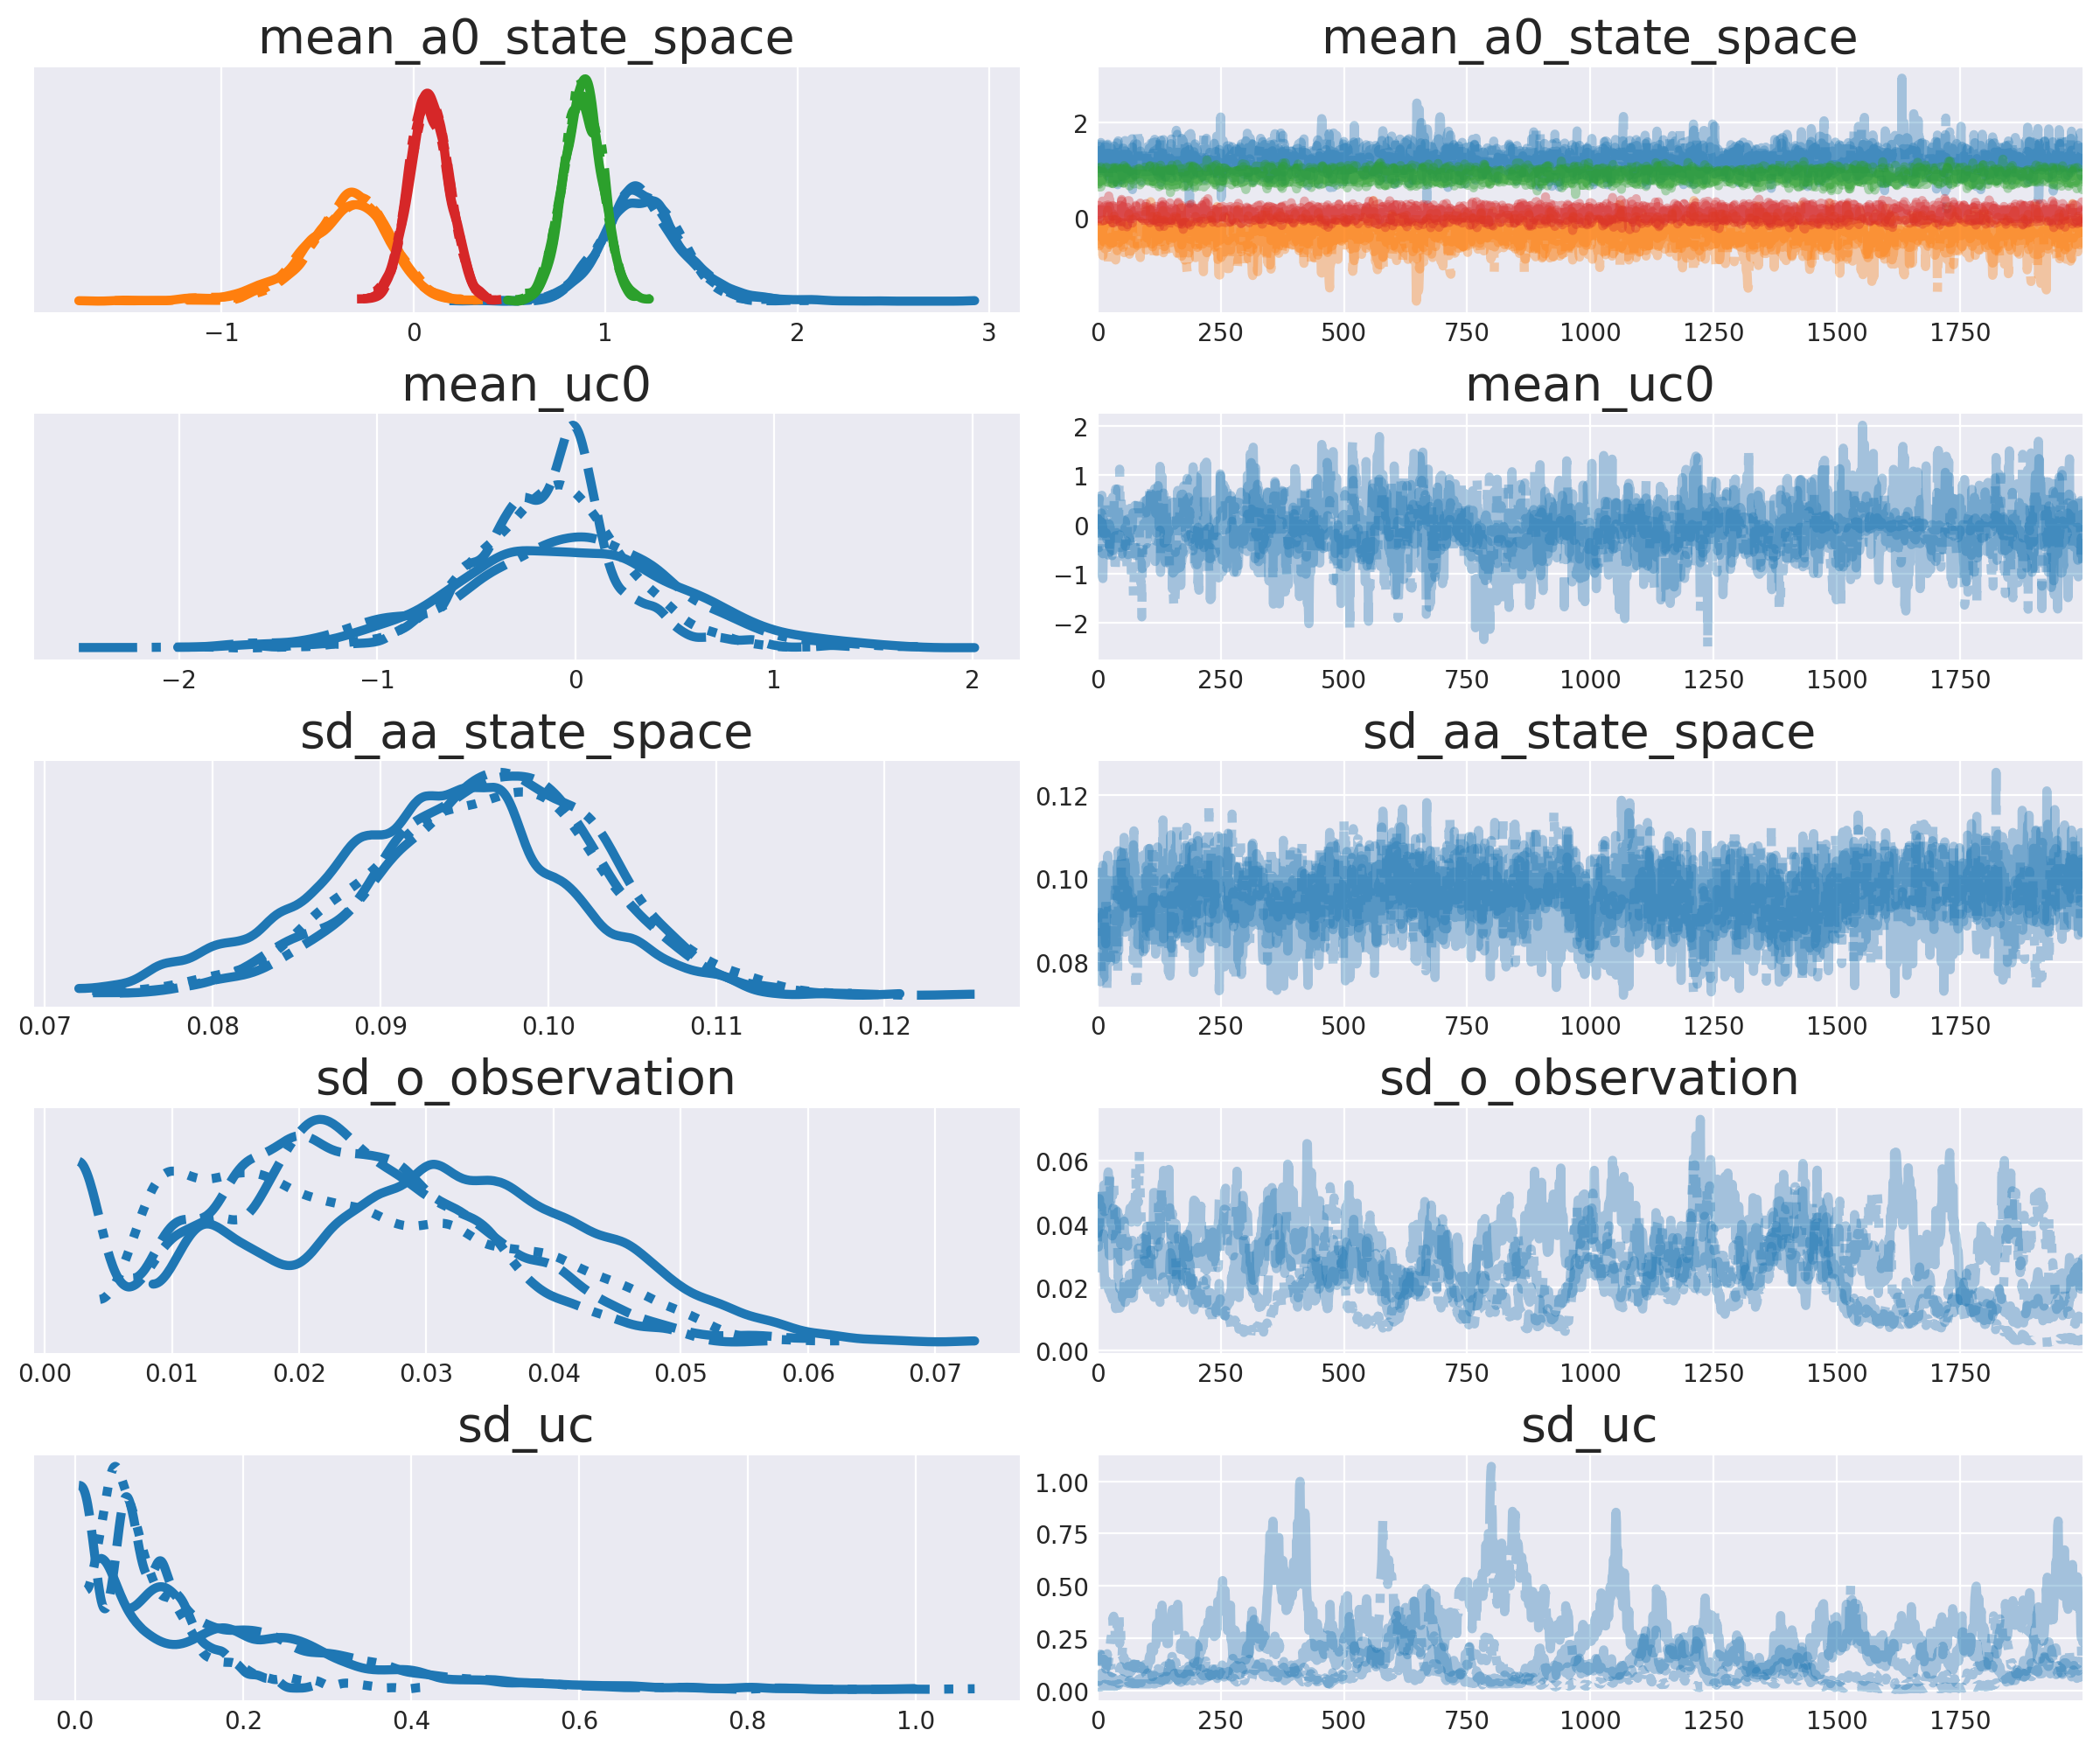

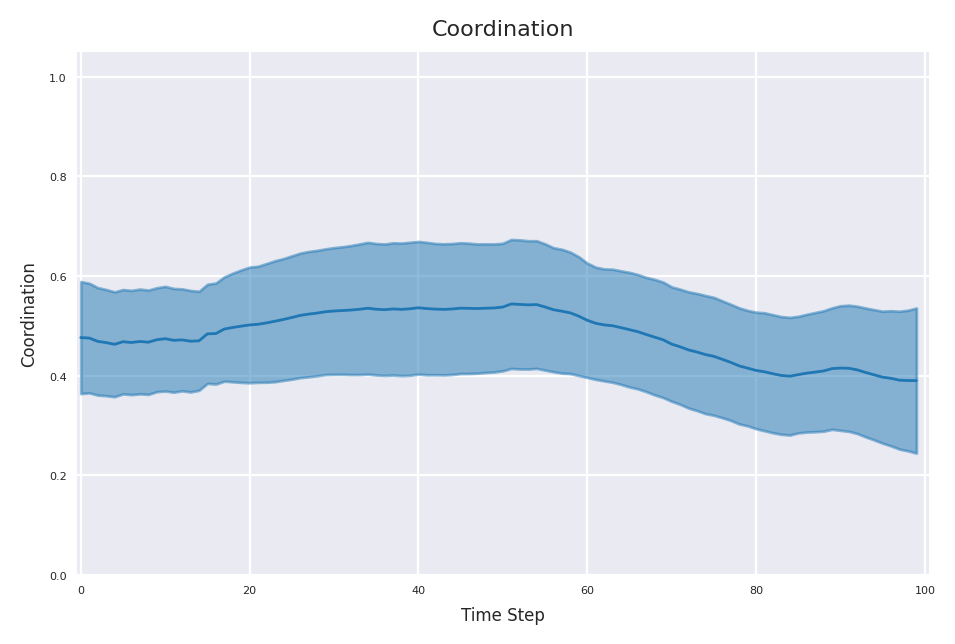

In [22]:
evidence = noisy_argument_coordinated_data

c_posterior_argument_coordinated, idata_argument_coordinated = train(argument_model, evidence, burn_in=BURN_IN, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, init_method=NUTS_INIT_METHOD)
build_convergence_summary(idata_argument_coordinated)

## 3) Supercoordination

### 3.1) Spring

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_uc0, sd_uc, unbounded_coordination, mean_a0_state_space, sd_aa_state_space, mixture_weights_state_space, state_space, sd_o_observation]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 160 seconds.


variable  mean_rhat  std_rhat
0                     mean_uc0   1.009828  0.000000
1       unbounded_coordination   1.045035  0.008267
2          mean_a0_state_space   1.001186  0.000466
3                  state_space   1.000685  0.000544
4                        sd_uc   1.047835  0.000000
5            sd_aa_state_space   1.004551  0.000000
6  mixture_weights_state_space   1.000654  0.000662
7             sd_o_observation   1.003587  0.000000
8                 coordination   1.044847  0.008392

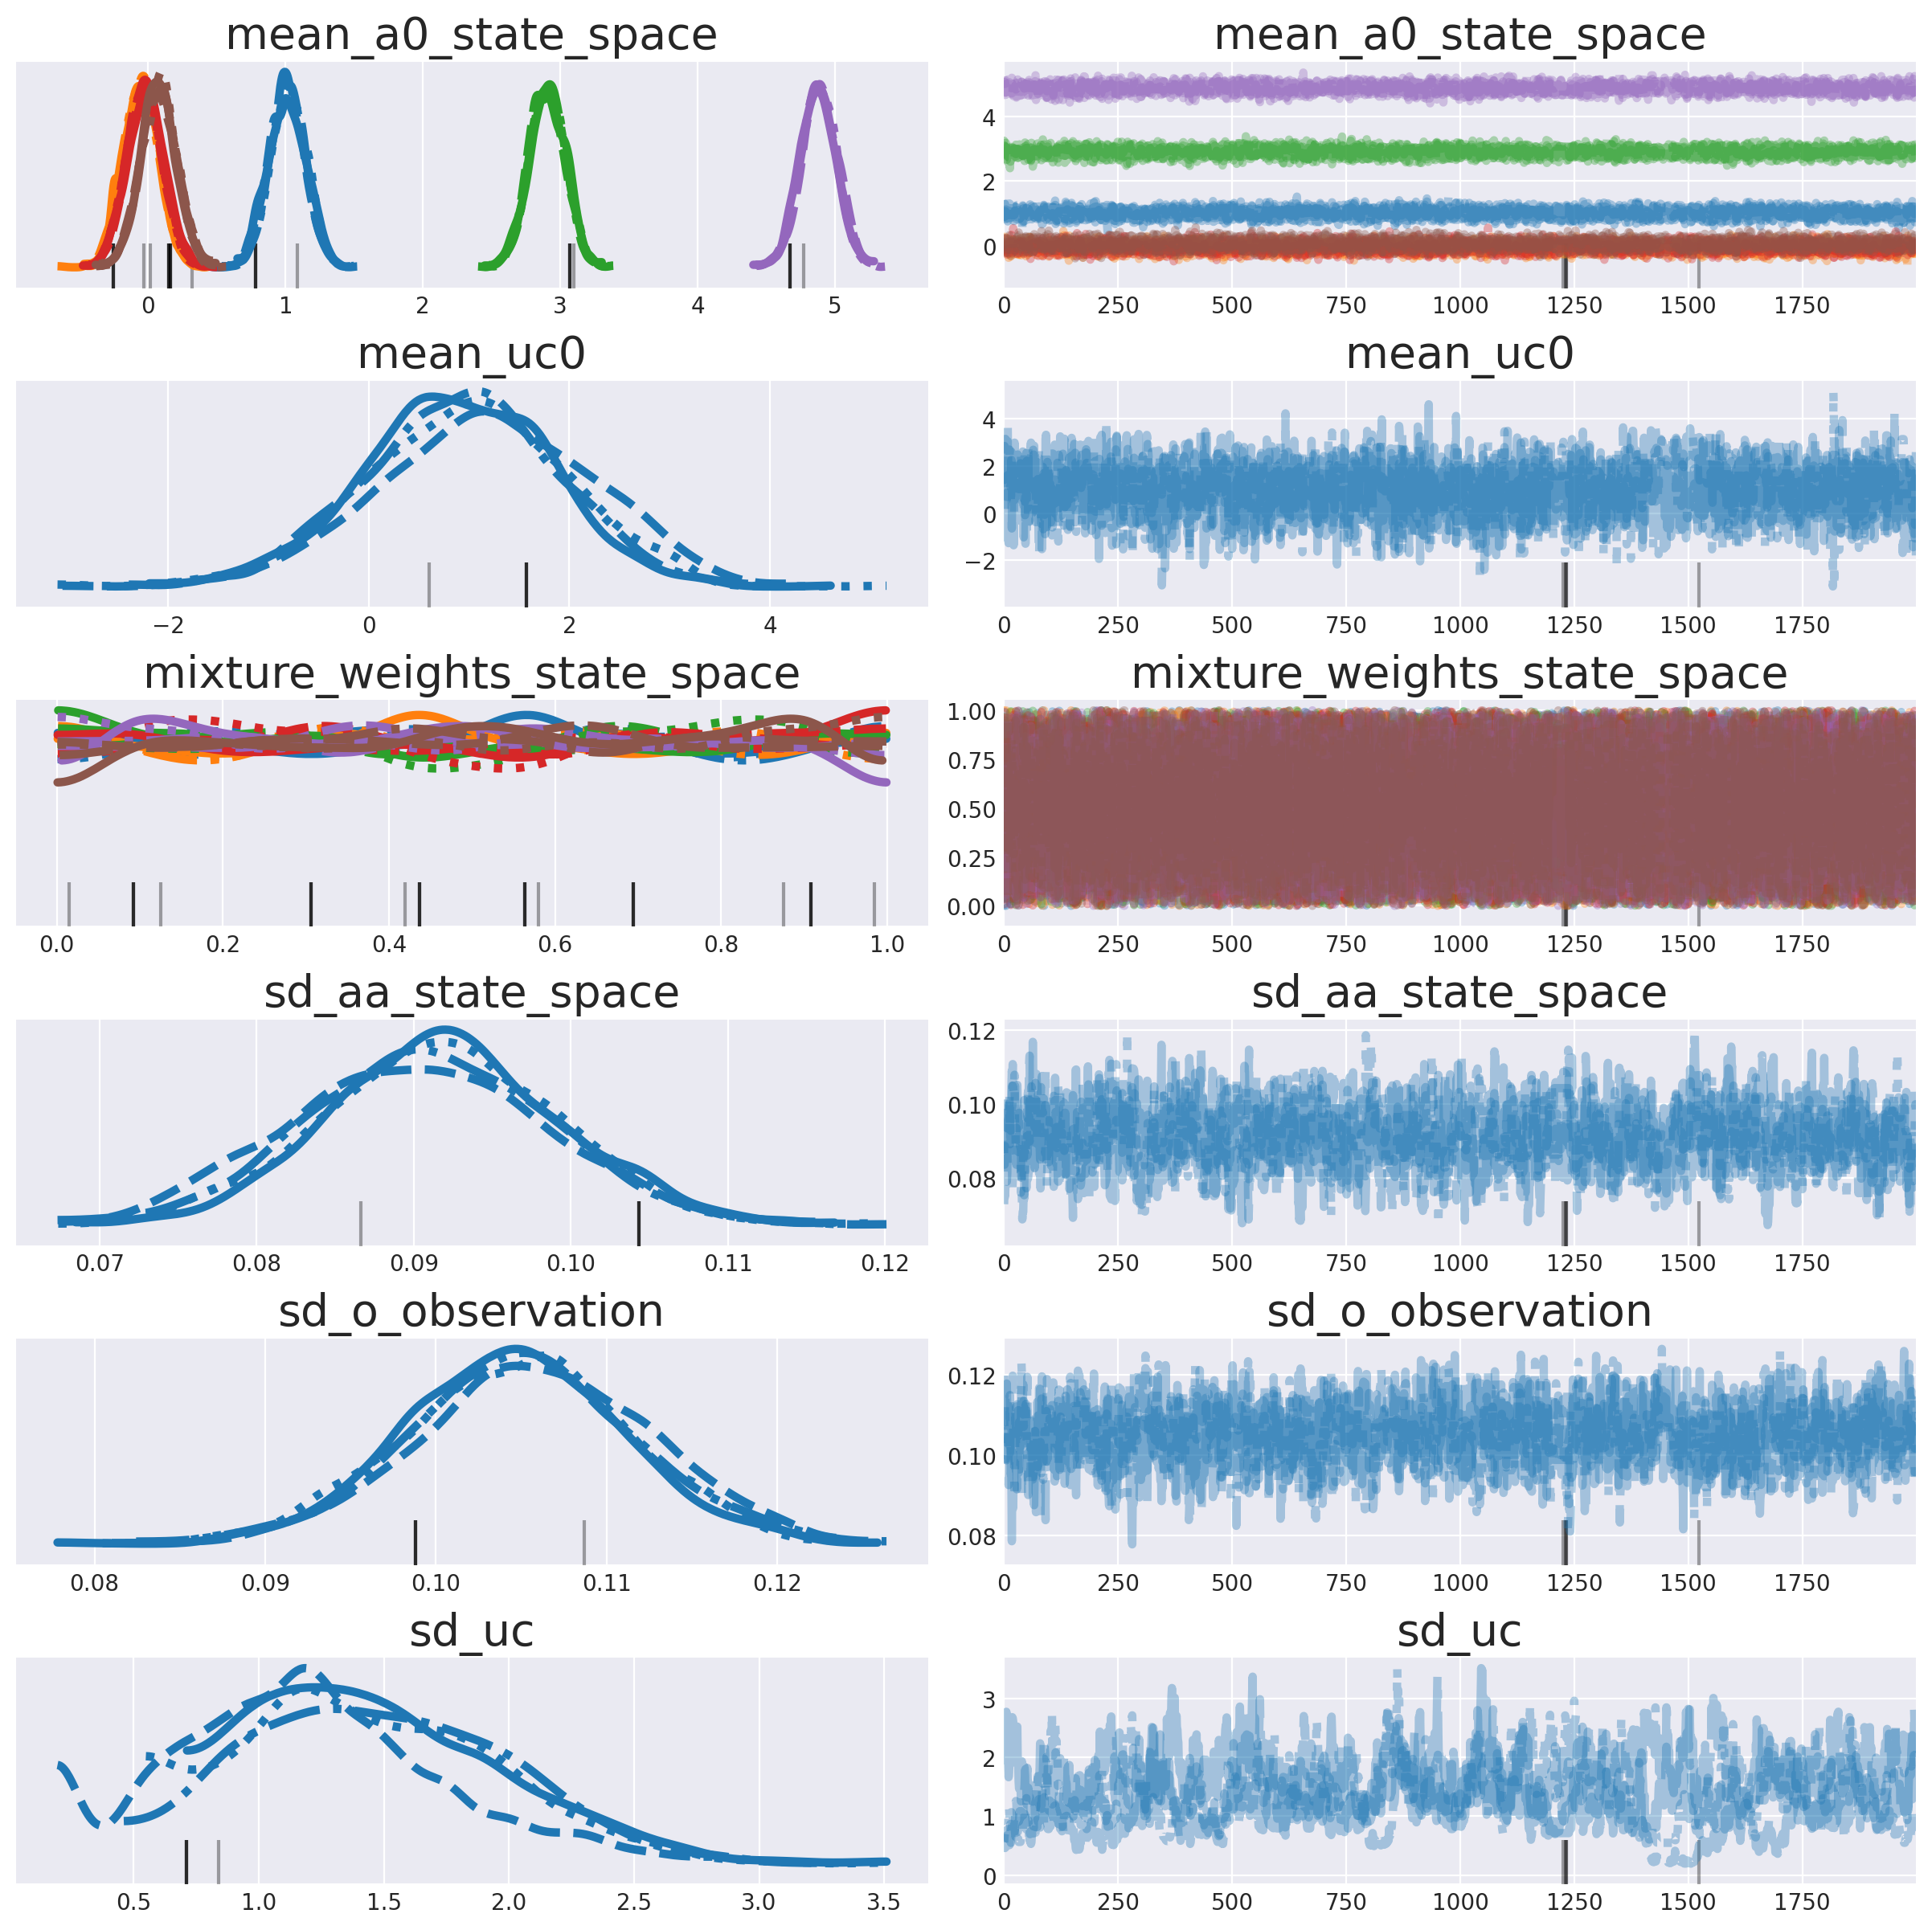

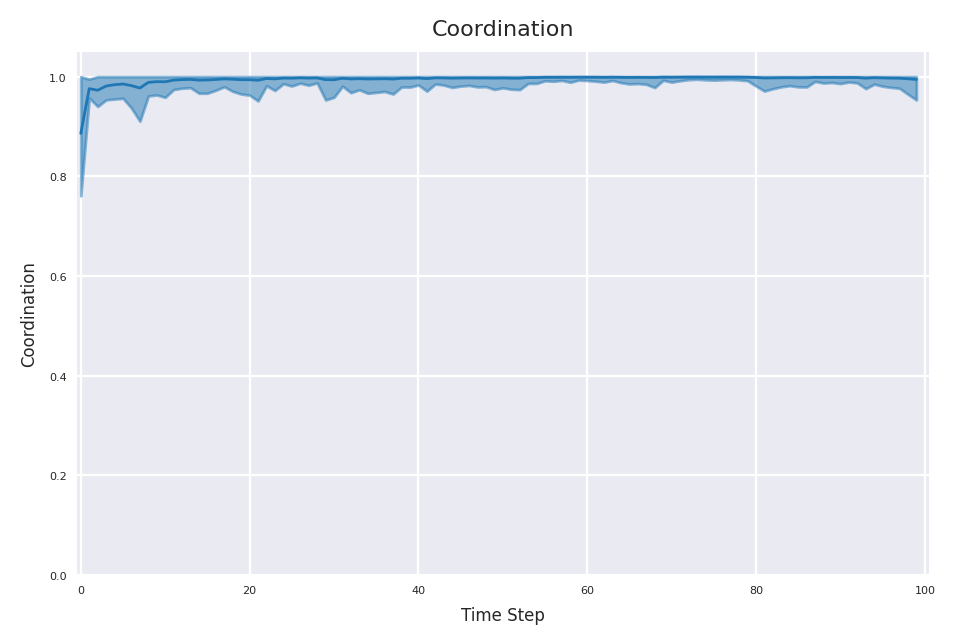

In [32]:
evidence = noisy_spring_supercoordinated_data

c_posterior_spring_supercoordinated, idata_spring_supercoordinated = train(spring_model, evidence, burn_in=BURN_IN, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, init_method=NUTS_INIT_METHOD)
build_convergence_summary(idata_spring_supercoordinated)

### 3.2) Argument

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_uc0, sd_uc, unbounded_coordination, mean_a0_state_space, sd_aa_state_space, state_space, sd_o_observation]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 357 seconds.


variable  mean_rhat  std_rhat
0                mean_uc0   1.017532  0.000000
1  unbounded_coordination   1.113826  0.031293
2     mean_a0_state_space   1.001977  0.001058
3             state_space   1.031492  0.003979
4                   sd_uc   1.176443  0.000000
5       sd_aa_state_space   1.019001  0.000000
6        sd_o_observation   1.121553  0.000000
7            coordination   1.114048  0.031601

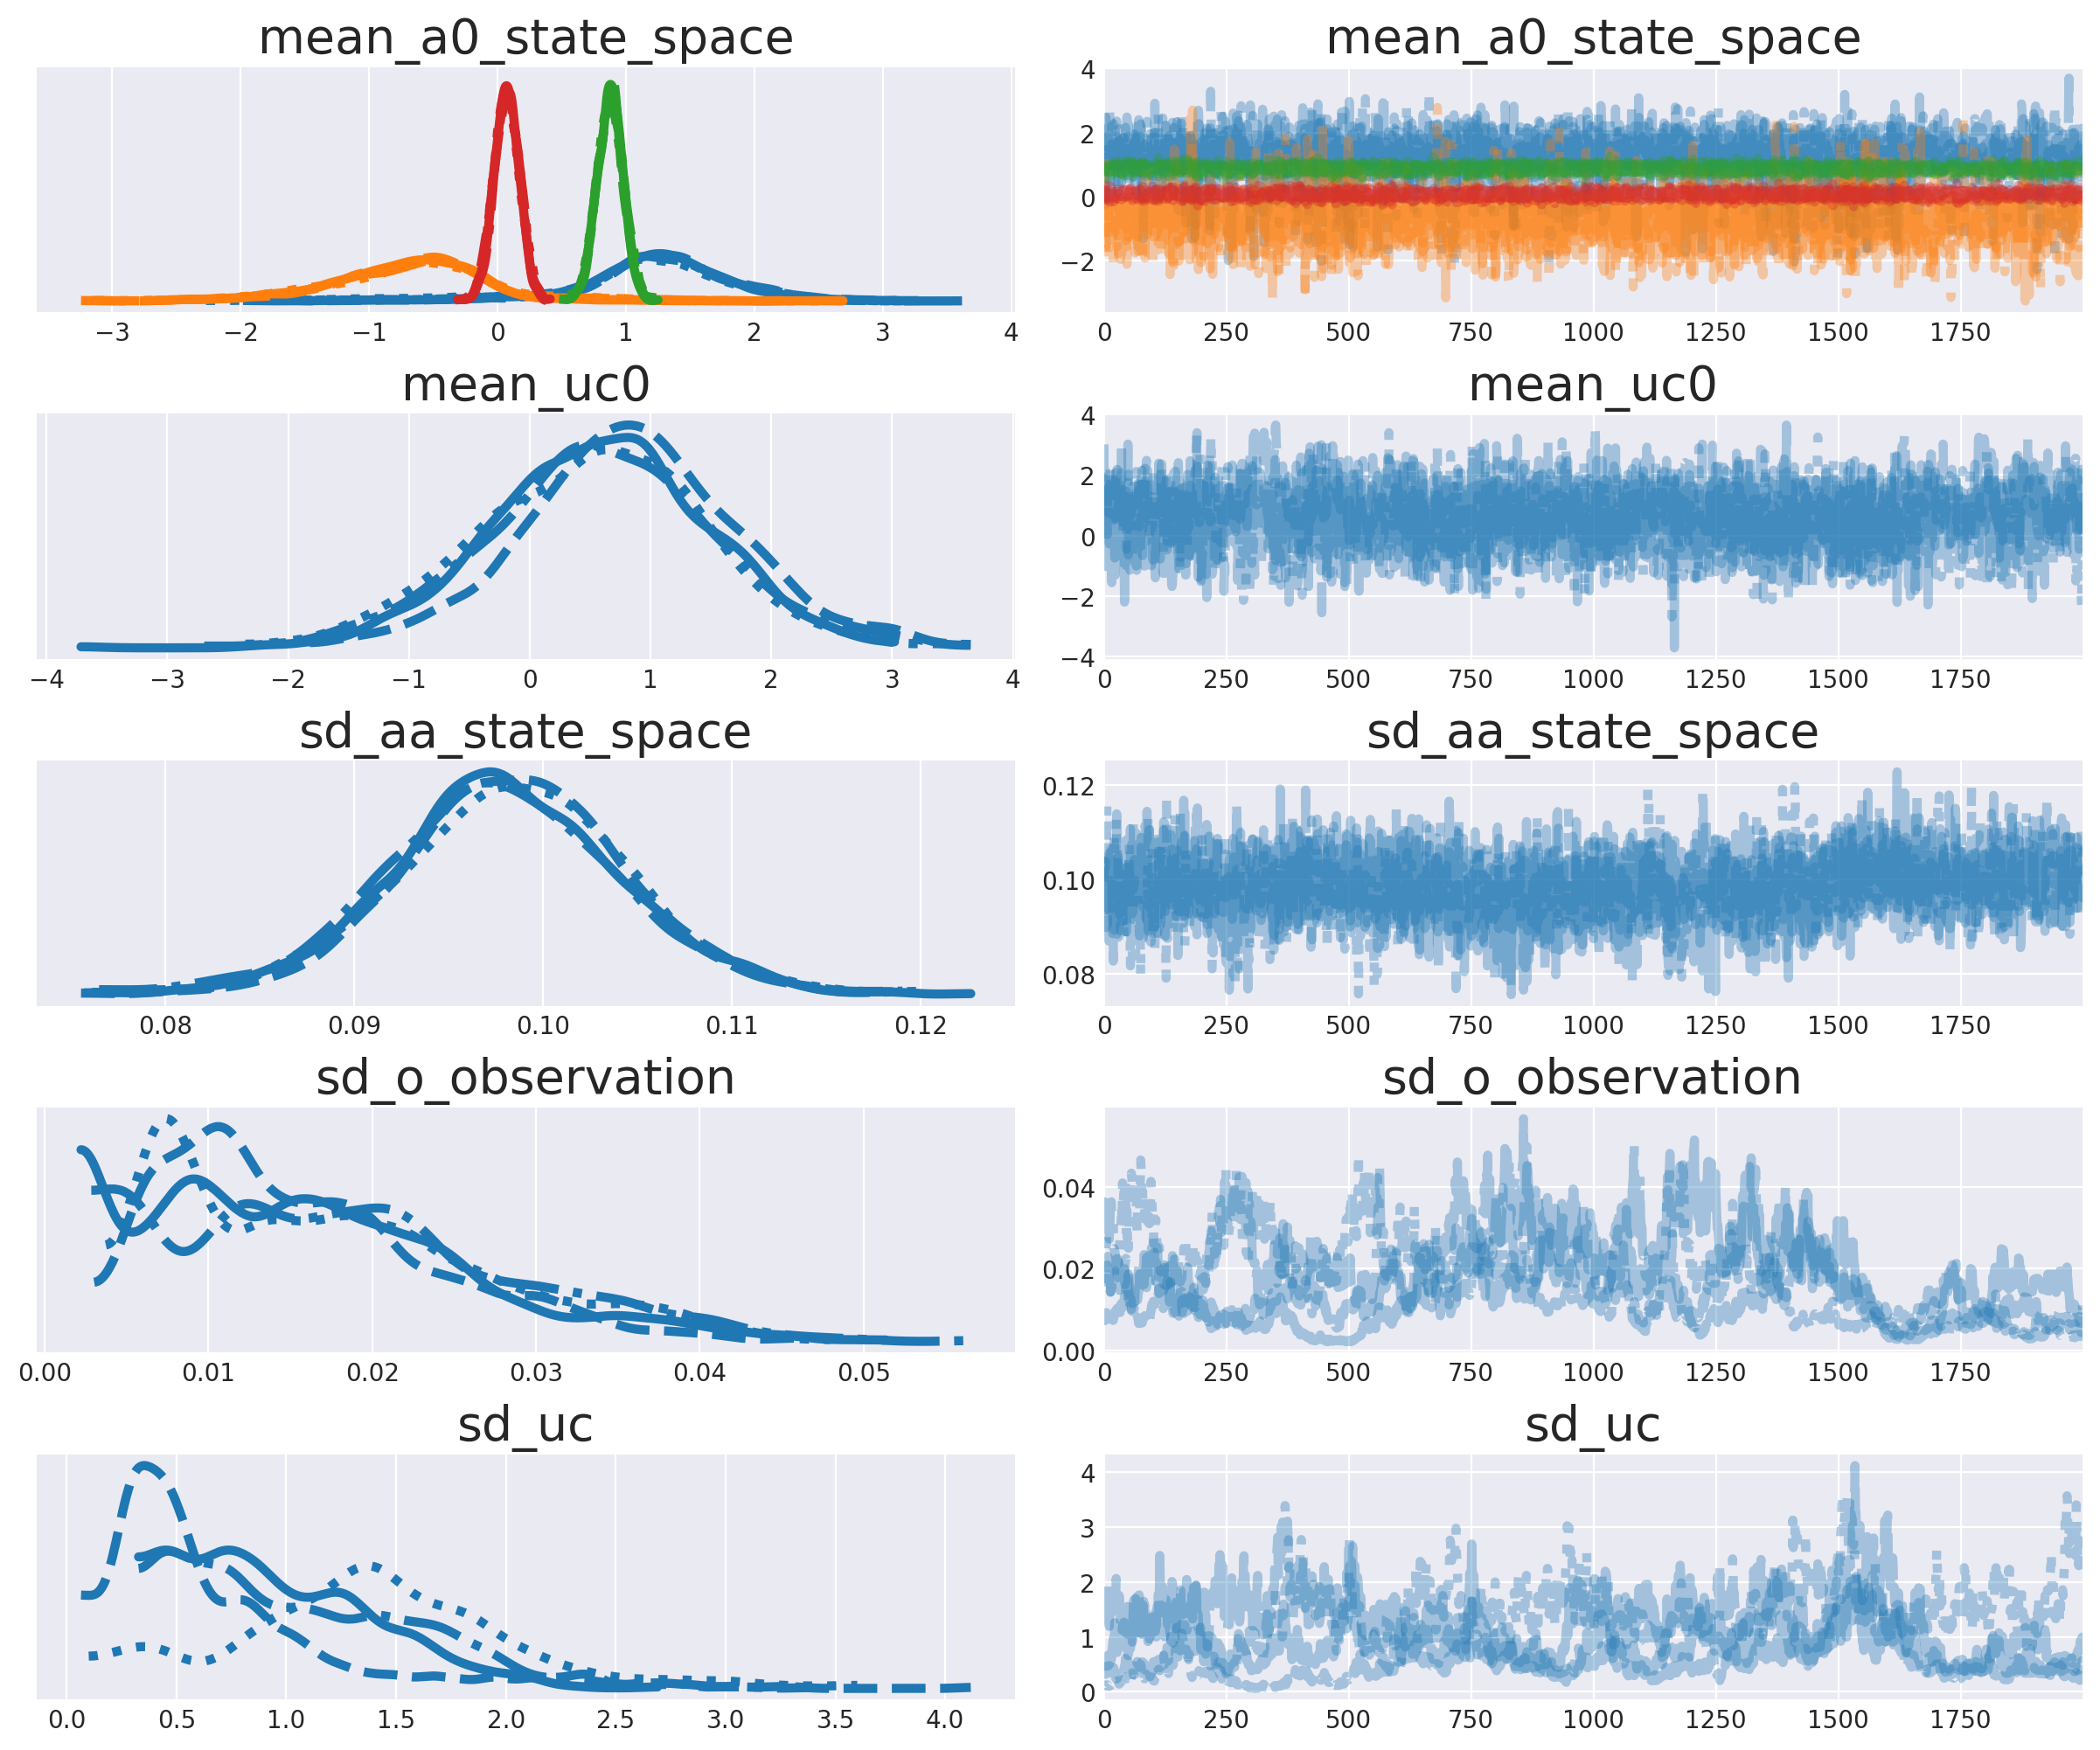

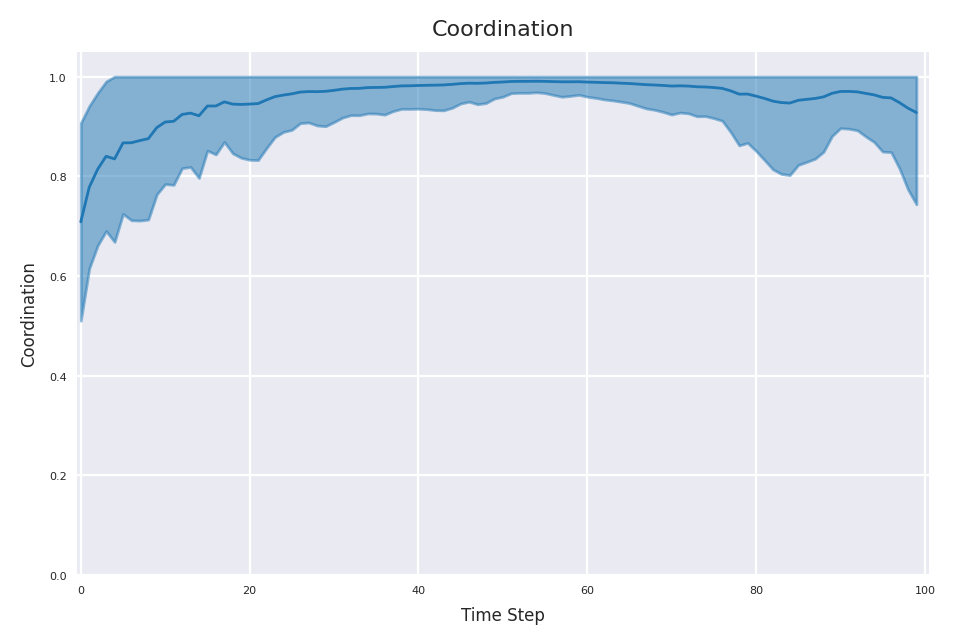

In [24]:
evidence = noisy_argument_supercoordinated_data

c_posterior_argument_supercoordinated, idata_argument_supercoordinated = train(argument_model, evidence, burn_in=BURN_IN, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, init_method=NUTS_INIT_METHOD)
build_convergence_summary(idata_argument_supercoordinated)

# Paper Plots

## a) Spring

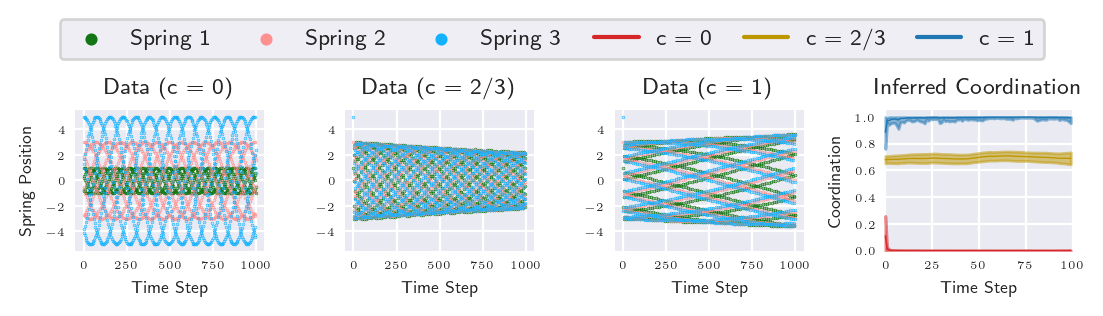

In [46]:
w, h = calculate_best_figure_dimensions(document_width=DOC, scale=1, subplots=(1,4))  
fig, axs = plt.subplots(1, 4, figsize=(w, h*1.5))
axs[1].sharey(axs[0])
axs[2].sharey(axs[0])

marker_size=0.05

# Data plots
plot_spring_data(axs[0], spring_uncoordinated_data[..., 0:-1:20], marker_size=marker_size, skip=1)
axs[0].set_ylabel("Spring Position")
axs[0].set_xlabel("Time Step")
axs[0].set_title("Data (c = 0)")

plot_spring_data(axs[1], spring_coordinated_data[..., 0:-1:20], marker_size=marker_size, skip=1)
axs[1].set_ylabel("")
axs[1].set_xlabel("Time Step")
# axs[1].set_yticklabels([])
axs[1].set_title("Data (c = 2/3)")

plot_spring_data(axs[2], spring_supercoordinated_data[..., 0:-1:20], marker_size=marker_size, skip=1)
axs[2].set_ylabel("")
axs[2].set_xlabel("Time Step")
# axs[1].set_yticklabels([])
axs[2].set_title("Data (c = 1)")

c_posterior_spring_uncoordinated.plot(axs[3], show_samples=False, line_width=0.5, color="tab:red", label="c = 0")
c_posterior_spring_coordinated.plot(axs[3], show_samples=False, line_width=0.5, color=MUSTARD, label="c = 2/3")
c_posterior_spring_supercoordinated.plot(axs[3], show_samples=False, line_width=0.5, color="tab:blue", label="c = 1")
axs[3].set_title("Inferred Coordination")
axs[3].set_xlabel("")
axs[3].set_ylabel("Coordination")
axs[3].set_xlabel("Time Step")

handles, labels = axs[0].get_legend_handles_labels()
handles_c, labels_c = axs[3].get_legend_handles_labels()
handles.extend(handles_c)
labels.extend(labels_c)
leg = fig.legend(handles, labels, loc='upper center', ncol=7, bbox_to_anchor=[0.5, 1.2], frameon=True, markerscale=15, columnspacing=1.4)
for line in leg.get_lines():
    line.set_linewidth(1.5)
# handles, labels = axs[2,0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=[0.5, 1.07], frameon=True, markerscale=2, title="Argument Model")

# plt.subplots_adjust(wspace=0)
plt.tight_layout()
save_plot("results_spring_model", fig)

## b) Argument model

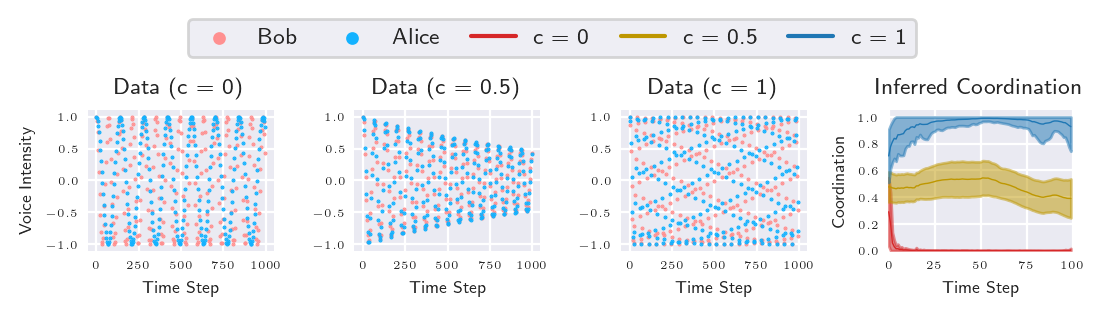

In [47]:
w, h = calculate_best_figure_dimensions(document_width=DOC, scale=1, subplots=(1,4))  
fig, axs = plt.subplots(1, 4, figsize=(w, h*1.5))
axs[1].sharey(axs[0])
axs[2].sharey(axs[0])

marker_size=0.2

# Data plots
plot_argument_data(axs[0], argument_uncoordinated_data, marker_size=marker_size, skip=1)
axs[0].set_ylabel("Voice Intensity")
axs[0].set_xlabel("Time Step")
axs[0].set_title("Data (c = 0)")

plot_argument_data(axs[1], argument_coordinated_data, marker_size=marker_size, skip=1)
axs[1].set_ylabel("")
axs[1].set_xlabel("Time Step")
# axs[1].set_yticklabels([])
axs[1].set_title("Data (c = 0.5)")

plot_argument_data(axs[2], argument_supercoordinated_data, marker_size=marker_size, skip=1)
axs[2].set_ylabel("")
axs[2].set_xlabel("Time Step")
# axs[1].set_yticklabels([])
axs[2].set_title("Data (c = 1)")

c_posterior_argument_uncoordinated.plot(axs[3], show_samples=False, line_width=0.5, color="tab:red", label="c = 0")
c_posterior_argument_coordinated.plot(axs[3], show_samples=False, line_width=0.5, color=MUSTARD, label="c = 0.5")
c_posterior_argument_supercoordinated.plot(axs[3], show_samples=False, line_width=0.5, color="tab:blue", label="c = 1")
axs[3].set_title("Inferred Coordination")
axs[3].set_xlabel("")
axs[3].set_ylabel("Coordination")
axs[3].set_xlabel("Time Step")

handles, labels = axs[0].get_legend_handles_labels()
handles_c, labels_c = axs[3].get_legend_handles_labels()
handles.extend(handles_c)
labels.extend(labels_c)
leg = fig.legend(handles, labels, loc='upper center', ncol=6, bbox_to_anchor=[0.5, 1.2], frameon=True, markerscale=8, columnspacing=1.4)
for line in leg.get_lines():
    line.set_linewidth(1.5)

# plt.subplots_adjust(wspace=0)
plt.tight_layout()
save_plot("results_argument_model", fig)